# Final Processing
The final processing stage requires:
1. Quick validation of catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue

In [1]:
import seaborn as sns
from astropy.table import Table
%matplotlib inline
import numpy as np
import pylab as plt

## Read tables

In [2]:
cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-15_cat.fits')
from astropy import units as u
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [3]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J142115.463-022453.614,215.31442836,-2.41489280701,3.33468,6.60541,0.977734,3.73737,6.8755,1.1498,4.78272,8.09562,1.63176,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.998893,1.00027,0.999239,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142116.253-022448.612,215.317718917,-2.41350327602,3.06678,5.90271,0.988912,3.29078,6.37985,1.10038,4.67175,7.98789,1.51281,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.999243,1.00173,0.998849,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142117.382-022449.913,215.322425171,-2.41386464826,3.42386,6.58129,1.15007,3.47816,6.77254,1.0564,4.14287,7.4328,1.49254,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.999352,0.999568,1.00006,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142118.091-022349.653,215.325378021,-2.39712587608,4.21498,7.38732,1.40758,4.86705,7.97514,1.70638,5.6521,8.57136,2.15265,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.998602,0.999211,1.00074,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142118.311-022504.062,215.32629573,-2.41779513571,3.56325,6.65995,1.1539,3.39464,6.69088,1.09852,3.90346,7.36287,1.22091,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.99857,0.999134,0.999128,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142119.582-022456.149,215.331591446,-2.41559696333,3.71537,6.90178,1.26441,3.5879,6.55285,1.2086,3.86527,7.49014,1.01593,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.998736,1.00004,0.999606,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142119.780-022520.124,215.332415815,-2.42225661831,3.89813,6.88817,1.33491,4.21243,7.2494,1.56672,5.14322,8.28733,1.79466,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.998826,0.998835,0.998958,2000.0,2000.0,2000.0,0.0,0.0,0.0
HELP_J142119.822-022436.765,215.33259349,-2.41021239083,3.38806,7.04718,0.966515,2.75994,5.7905,0.759195,3.02711,6.57699,0.894145,-1.89622,-3.5095,-7.79973,0.138529,0.180141,0.250311,0.999211,0.998772,1.00037,2000.0,2000.0,2000.0,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

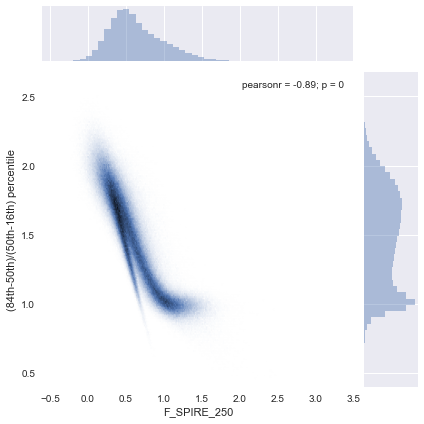

In [4]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')

For 250 $\mathrm{\mu m}$ depth is ~ 4mJy

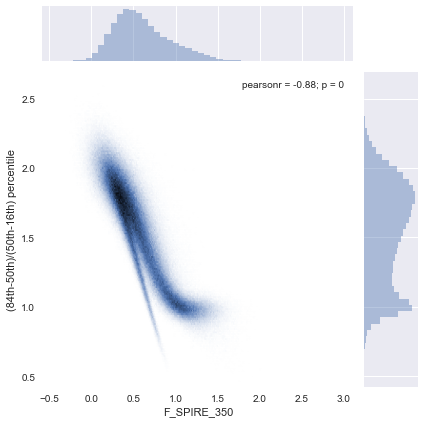

In [6]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')

For 350 $\mathrm{\mu m}$ depth is ~ 6mJy

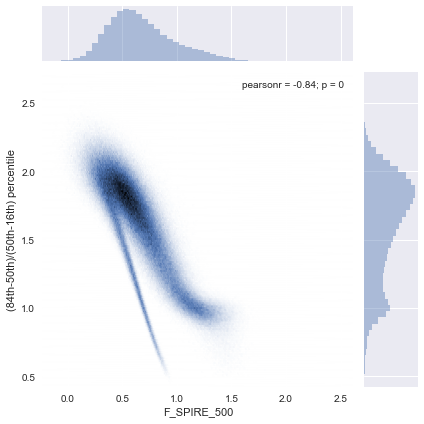

In [7]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')

For 500 $\mathrm{\mu m}$ depth is ~ 10mJy

## Add flag to catalogue

In [8]:
from astropy.table import Column
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [9]:
ind_SERVS_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 4)
ind_SERVS_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 6)
ind_SERVS_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 10)

In [10]:
print(ind_SERVS_250.sum(),ind_SERVS_350.sum(),ind_SERVS_500.sum(),len(cat))

673633 914838 1059715 1236395


In [12]:
cat['flag_spire_250'][ind_SERVS_250]=True
cat['flag_spire_350'][ind_SERVS_350]=True
cat['flag_spire_500'][ind_SERVS_500]=True

In [13]:
cat.write('./data/dmu26_XID+SPIRE_GAMA-15_cat_20180416.fits', format='fits',overwrite=True)